In [22]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter



# 读取数据，请确保路径正确
path_to_excel = r"新建 XLSX 工作表.xlsx"
df = pd.read_excel(path_to_excel, sheet_name=0)
if pd.api.types.is_numeric_dtype(df['日期']):  
    df['日期'] = pd.to_datetime(df['日期'], origin='1877-12-29' , unit='D', errors='coerce')
else:  
    df['日期'] = pd.to_datetime(df['日期'], errors='coerce')

valid_dates = df['日期'].dropna()
if not valid_dates.empty:
    reference_date = valid_dates.min()
    df['day_index'] = (df['日期'] - reference_date).dt.days
else:
    raise ValueError("日期列无有效数据，无法继续处理")
critical_data_cols = ['day_index', '已确诊病例累计', '现有疑似病例','死亡累计', '治愈出院累计']
df = df.dropna(subset=critical_data_cols).reset_index(drop=True)
df = df.drop_duplicates(subset=['day_index'], keep='last').reset_index(drop=True)


# ----------------------
# 1. 数据准备
# ----------------------
t_obs = df['day_index'].values
C_obs = df['已确诊病例累计'].values
E_obs = df['现有疑似病例'].values
R_obs = df['治愈出院累计'].values
D_obs = df['死亡累计'].values
I_obs = C_obs - R_obs - D_obs  
N = 10_000_000  # 总人口
S_obs = N - E_obs - I_obs - D_obs - R_obs  


# 确保观测值非负
for var in [S_obs, E_obs, I_obs, R_obs, D_obs, C_obs]:
    assert np.all(var >= 0), "观测值存在负值，请检查数据！"



# ----------------------
# 2. 定义SEIRD模型
# ----------------------
def seir_model(t_obs, theta, y0):
    beta0, beta1, t_int, sigma, mu, dead = theta
    N = 10_000_000  # 总人口
    
    def odefun(t, y):
        S, E, I, R, D = y
        # 分段感染率（连续过渡）
        if t < t_int:
            b = beta0
        elif t < t_int + 10:
            b = beta0 - (beta0 - beta1) * ((t - t_int) / 10.0)
        else:
            b = beta1
        
        dSdt = -b * S * I / N 
        dEdt = b * S * I / N - sigma * E
        dIdt = sigma * E - (mu + dead) * I  
        dRdt = mu * I
        dDdt = dead * I
        return [dSdt, dEdt, dIdt, dRdt, dDdt]
    
    # 求解ODE
    sol = solve_ivp(
        odefun, 
        t_span=[t_obs[0], t_obs[-1]], 
        y0=y0, 
        t_eval=t_obs, 
        method='LSODA',  # 自适应步长求解器
        rtol=1e-8, atol=1e-8  # 提高求解精度
    )
    S_pred, E_pred, I_pred, R_pred, D_pred = sol.y
    C_pred = I_pred + R_pred + D_pred  
    
    return S_pred, E_pred, I_pred, R_pred, D_pred, C_pred



# ----------------------
# 3. 定义综合损失函数
# ----------------------
def combined_loss(theta, t_obs, y_obs, y0):
    S_obs, E_obs, I_obs, R_obs, D_obs, C_obs = y_obs  
    S_pred, E_pred, I_pred, R_pred, D_pred, C_pred = seir_model(t_obs, theta, y0)
    

    mse_S = np.mean((S_pred - S_obs)**2)
    mse_E = np.mean((E_pred - E_obs)**2)
    mse_I = np.mean((I_pred - I_obs)**2)
    mse_R = np.mean((R_pred - R_obs)**2)
    mse_D = np.mean((D_pred - D_obs)**2)
    mse_C = np.mean((C_pred - C_obs)**2)
    
    total_loss = mse_S + mse_E + mse_I + mse_R + mse_D + mse_C
    total_loss = mse_R
    return total_loss


# ----------------------
# 4. 参数定义
# ----------------------
# 初始参数定义
y0 = [N - 759.0, 402.0, 339.0, 33.0, 18.0]  # [S0, E0, I0, R0, D0]
theta_initial = [0.80, 0.10, 15.0, 1/5, 0.05, 0.02]  # [beta0, beta1, t_int, sigma, mu, dead]



# 参数边界
bounds = (
    (0.2, 1.0),       # beta0：感染率 > 0
    (0, 1.0),         # beta1：干预后感染率 < beta0
    (5.0, 25.0),      # t_int：政策时间在观测范围内（连续优化后取整）
    (1/21, 1),        # sigma：潜伏期倒数（潜伏期2-14天）
    (0.08, 1),        # mu：康复率（康复期2-14天）
    (0.04, 1),        # dead：死亡率通常较低（0~5%）
)

In [23]:

# 优化过程
result = minimize(
    combined_loss, 
    theta_initial, 
    args=(t_obs, (S_obs, E_obs, I_obs, R_obs, D_obs, C_obs), y0), 
    bounds=bounds, 
    method='trust-constr',  
    options={
        'maxiter': 2000, 
        'xtol': 1e-12,  # 参数变化容差
        'gtol': 1e-10,  # 梯度容差
        'verbose': 2
    }
)

# 处理离散参数t_int
theta_optimized = result.x.copy()
theta_optimized[2] = np.round(theta_optimized[2])  # 转换为整数时间点

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   7   |   0   | +3.6077e+10 | 1.00e+00 | 7.17e+11 | 3.00e-02 |
|   2   |  14   |   1   | +3.7270e+05 | 1.00e+00 | 4.41e+05 | 0.00e+00 |
|   3   |  21   |   7   | +3.7270e+05 | 6.41e+00 | 2.96e+05 | 0.00e+00 |
|   4   |  28   |  13   | +3.7254e+05 | 1.09e+01 | 1.33e+05 | 0.00e+00 |
|   5   |  35   |  19   | +3.6337e+05 | 1.09e+01 | 1.16e+05 | 0.00e+00 |
|   6   |  42   |  25   | +3.5132e+05 | 1.09e+01 | 1.46e+05 | 0.00e+00 |
|   7   |  49   |  31   | +3.2209e+05 | 1.09e+01 | 6.82e+04 | 0.00e+00 |
|   8   |  56   |  37   | +3.1676e+05 | 1.09e+01 | 3.75e+04 | 0.00e+00 |
|   9   |  63   |  43   | +3.1602e+05 | 1.09e+01 | 1.49e+04 | 0.00e+00 |
|  10   |  70   |  49   | +3.1599e+05 | 1.09e+01 | 1.88e+04 | 0.00e+00 |
|  11   |  84   |  55   | +3.1599e+05 | 1.09e+00 | 1.88e+04 | 0.00e+00 |
|  12   |  91   |  61   | +3.1598e+05 | 1.09e+00 | 

Optimized Parameters:
['beta0', 'beta1', 't_int', 'sigma', 'mu', 'dead']
[ 0.99998691  0.68463264 25.          0.0476302   0.08000499  0.347829  ]
Total Loss: 13632.82


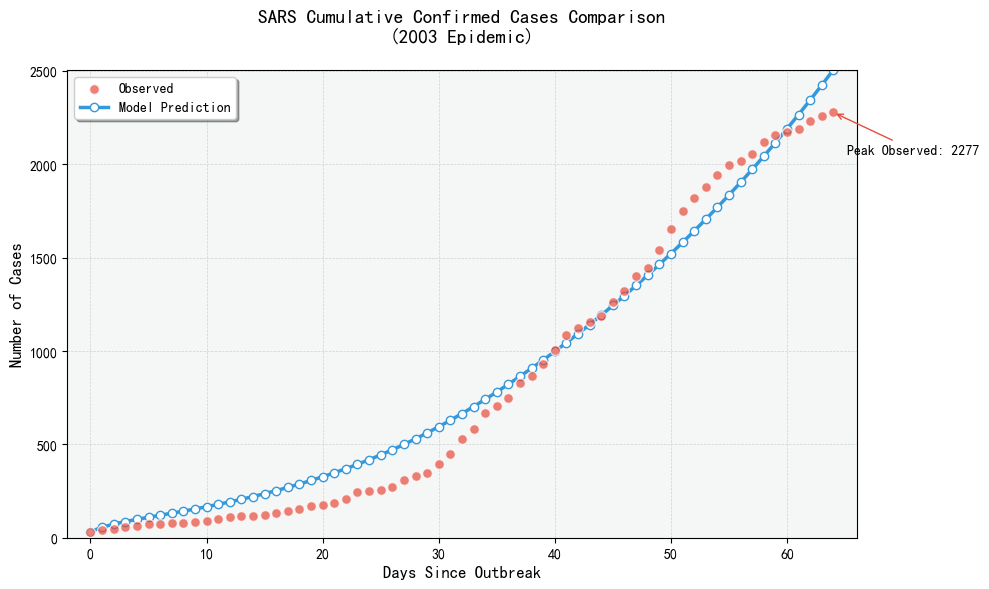

In [24]:
# ----------------------
# 5. 结果验证与可视化
# ----------------------


# 获取优化后的预测值
S_pred, E_pred, I_pred, R_pred, D_pred, C_pred = seir_model(
    t_obs, theta_optimized, y0
)


# 定义变量名称和对应数据
variables = [
    ('S', S_obs, S_pred),
    ('E', E_obs, E_pred),
    ('I', I_obs, I_pred),
    ('R', R_obs, R_pred),
    ('D', D_obs, D_pred),
    ('C', C_obs, C_pred)
]



# 输出优化结果
print("Optimized Parameters:")
print(["beta0", "beta1", "t_int", "sigma", "mu", "dead"])
print(theta_optimized)
print(f"Total Loss: {result.fun:.2f}")


# ----------------------
# 6 绘制单变量对比图
# ----------------------
def plot(t_obs, C_obs, C_pred):

    plt.figure(figsize=(10, 6))

    # 使用专业的配色方案
    obs_color = '#E74C3C'  
    pred_color = '#3498DB'

    # 绘制观测值散点图
    plt.scatter(t_obs, C_obs, 
           label='Observed', 
           color=obs_color, 
           s=50, 
           alpha=0.7,
           edgecolor='white',
           zorder=3)

    # 绘制预测曲线
    plt.plot(t_obs, C_pred, 
        label='Model Prediction', 
        color=pred_color, 
        linewidth=2.5,
        linestyle='-',
        marker='o',
        markersize=6,
        markerfacecolor='white',
        markeredgecolor=pred_color,
        zorder=2)

    # 添加图例和标签
    plt.title('SARS Cumulative Confirmed Cases Comparison\n(2003 Epidemic)', 
         fontsize=14, pad=20)
    plt.xlabel('Days Since Outbreak', fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    plt.legend(frameon=True, 
          loc='upper left', 
          fontsize=10,
          shadow=True,
          facecolor='white')

    # 美化坐标轴
    plt.grid(True, 
        color='#BDC3C7', 
        linestyle='--', 
        linewidth=0.5,
        alpha=0.7)
    plt.gca().set_facecolor('#F5F6F6')  # 浅灰色背景

    # 添加边距
    plt.xlim([t_obs.min()-2, t_obs.max()+2])
    plt.ylim([0, C_obs.max() * 1.1])

    # 优化刻度标签
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ticklabel_format(axis='y', style='plain') 

    # 添加数据标签
    max_obs = C_obs.max()
    max_pred = C_pred.max()
    plt.annotate(f'Peak Observed: {int(max_obs)}', 
            xy=(t_obs[C_obs.argmax()], max_obs),
            xytext=(10, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color=obs_color))

    plt.tight_layout()
    plt.show()


plot(t_obs, R_obs, R_pred)

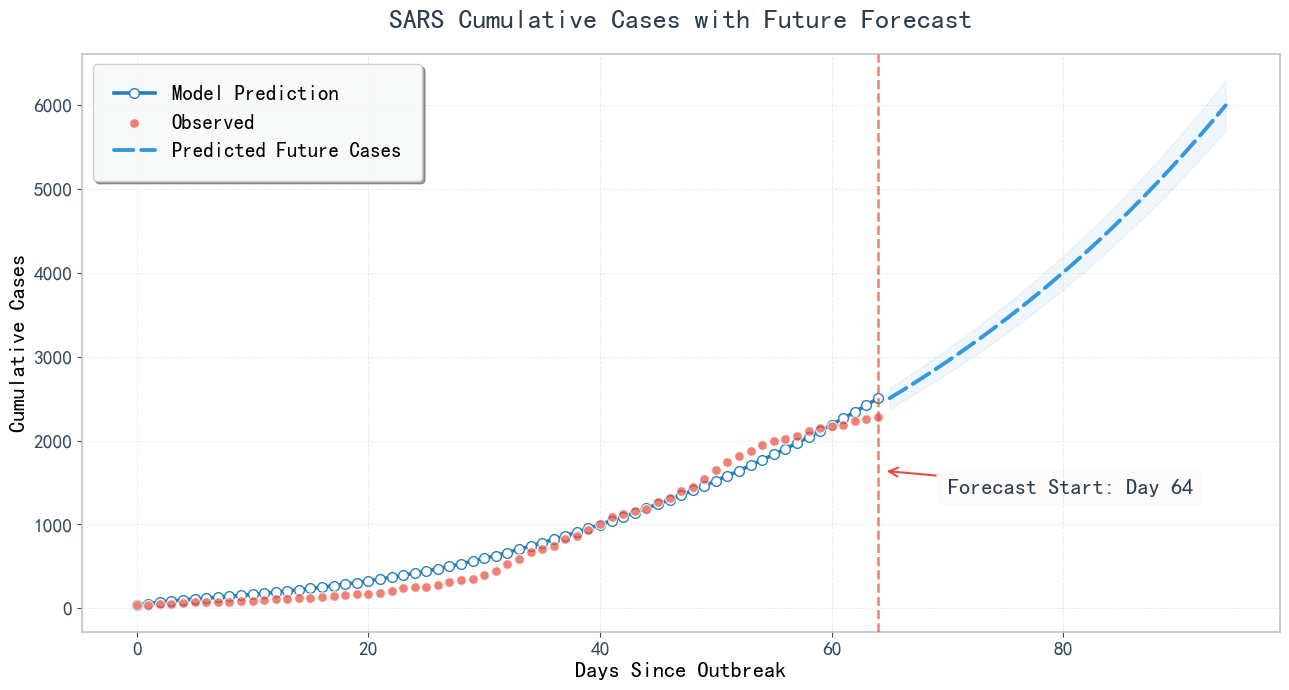


Future Forecast:
Day 65: Predicted Cases = 2506
Day 66: Predicted Cases = 2590
Day 67: Predicted Cases = 2676
Day 68: Predicted Cases = 2764
Day 69: Predicted Cases = 2855
Day 70: Predicted Cases = 2947
Day 71: Predicted Cases = 3042
Day 72: Predicted Cases = 3139
Day 73: Predicted Cases = 3239
Day 74: Predicted Cases = 3341
Day 75: Predicted Cases = 3446
Day 76: Predicted Cases = 3553
Day 77: Predicted Cases = 3662
Day 78: Predicted Cases = 3775
Day 79: Predicted Cases = 3890
Day 80: Predicted Cases = 4008
Day 81: Predicted Cases = 4129
Day 82: Predicted Cases = 4253
Day 83: Predicted Cases = 4380
Day 84: Predicted Cases = 4510
Day 85: Predicted Cases = 4643
Day 86: Predicted Cases = 4780
Day 87: Predicted Cases = 4920
Day 88: Predicted Cases = 5063
Day 89: Predicted Cases = 5210
Day 90: Predicted Cases = 5360
Day 91: Predicted Cases = 5514
Day 92: Predicted Cases = 5672
Day 93: Predicted Cases = 5834
Day 94: Predicted Cases = 5999


In [25]:
# ----------------------
# 7 未来预测
# ----------------------


# 生成未来时间点
future_days = 30   # 定义未来预测天数
t_future = np.arange(t_obs[-1]+1, t_obs[-1]+future_days+1)


_, *final_states = seir_model(t_obs, theta_optimized, y0)
S_final = S_pred[-1]
E_final = E_pred[-1]
I_final = I_pred[-1]
R_final = R_pred[-1]
D_final = D_pred[-1]
y0_future = [S_final, E_final, I_final, R_final, D_final]

# 进行未来预测
S_pred_f, E_pred_f, I_pred_f, R_pred_f, D_pred_f, C_pred_f = seir_model(
    t_future, 
    theta_optimized, 
    y0_future
)


# ----------------------
# 预测结果可视化
# ----------------------

def predict_plot(t_obs, C_obs, C_pred, t_future, C_pred_f):
    
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(13, 7), dpi=100)
    ax = plt.gca()

    # 配色方案
    hist_color = '#2980B9'    # 历史数据色
    pred_color = '#27AE60'    # 预测色
    line_color = '#E74C3C'    # 分割线色
    obs_color = '#E74C3C'  # 红色系
    pred_color = '#3498DB'  # 蓝色系

    # 历史数据
    plt.plot(t_obs, C_pred, 
             color=hist_color,
             linewidth=2.6,
             label='Model Prediction',
             zorder=2,
             marker='o',
             markersize=7,
             markeredgecolor=hist_color,
             markerfacecolor='white')
    
    # 观测数据散点
    plt.scatter(t_obs, C_obs, 
           label='Observed', 
           color=obs_color, 
           s=50, 
           alpha=0.7,
           edgecolor='white',
           zorder=3)

    # 预测曲线
    plt.plot(t_future, C_pred_f,
             color=pred_color,
             linewidth=2.8,
             linestyle=(0, (5, 2)),
             label='Predicted Future Cases',
             zorder=3,
             dash_capstyle='round')

    # 预测区间阴影
    plt.fill_between(t_future,
                     C_pred_f*0.95,
                     C_pred_f*1.05,
                     color=pred_color,
                     alpha=0.08,
                     zorder=1)

    # 预测分界线
    cutoff = t_obs[-1]
    plt.axvline(cutoff, 
                color=line_color,
                linewidth=1.8,
                linestyle='--',
                alpha=0.7,
                zorder=4)

    # 分界线标注
    plt.annotate(f'Forecast Start: Day {int(cutoff)}',
                 xy=(cutoff+0.5, C_obs[-1]*0.72),
                 xytext=(cutoff+6, C_obs[-1]*0.6),
                 arrowprops=dict(arrowstyle='->',
                                 color=line_color,
                                 linewidth=1.5),
                 fontsize=16,  
                 color='#2C3E50',
                 bbox=dict(boxstyle='round,pad=0.4',
                           alpha=0.1,
                           color='#FADBD8'))

    # 图表元数据
    ax.set_title('SARS Cumulative Cases with Future Forecast', 
                fontsize=20,  
                pad=18,
                color='#2C3E50')
    ax.set_xlabel('Days Since Outbreak', fontsize=16)  
    ax.set_ylabel('Cumulative Cases', fontsize=16)     

    # 统一样式元素
    ax.tick_params(axis='both', which='major', labelsize=14, colors='#34495E')  
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.3, color='#BDC3C7')

    # 图例样式继承
    legend = ax.legend(loc='upper left', 
                      fontsize=15,  
                      framealpha=0.95,
                      shadow=True,
                      borderpad=1)
    legend.get_frame().set_facecolor('#FDFEFE')

    # 边框颜色统一
    for spine in ax.spines.values():
        spine.set_color('#BDC3C7')
        spine.set_linewidth(1.2)

    plt.tight_layout()
    plt.show()

    print("\nFuture Forecast:")
    for i, (day, cases) in enumerate(zip(t_future, R_pred_f)):
        print(f"Day {int(day)}: Predicted Cases = {cases:.0f}")


predict_plot(t_obs, R_obs, R_pred, t_future, R_pred_f)